# [Lecture 05 - Elemental Confounds](https://youtu.be/mBEA7PKDmiY?si=b4vr1l9rogryaiEB)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2024-11-15T14:23:16.356895+01:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.15.0

Compiler    : MSC v.1936 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 4
Architecture: 64bit

arviz      : 0.16.1
statsmodels: 0.14.0
scipy      : 1.11.2
watermark  : 2.5.0
IPython    : 8.15.0
pandas     : 2.1.0
xarray     : 2023.8.0
pymc       : 5.8.0
matplotlib : 3.9.2
numpy      : 1.24.4



# Causation & Association
## Does Wafflehouse cause divorce?

In [2]:
WAFFLEHOUSE_DIVORCE = utils.load_data("WaffleDivorce")
WAFFLEHOUSE_DIVORCE.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


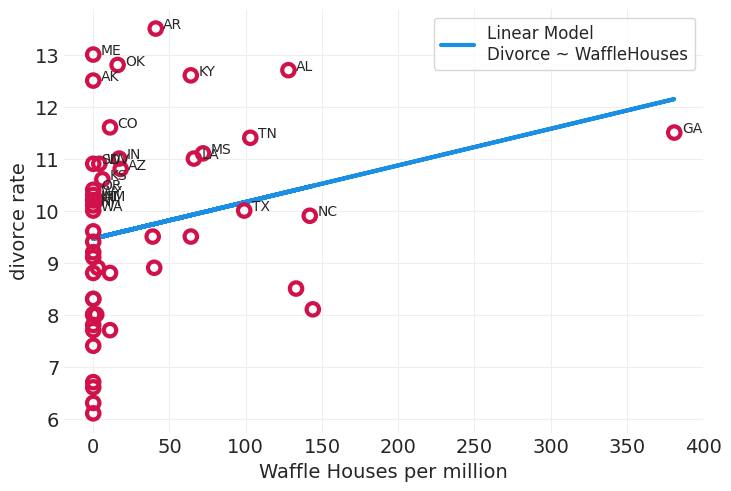

In [3]:
utils.plot_scatter(
    WAFFLEHOUSE_DIVORCE.WaffleHouses,
    WAFFLEHOUSE_DIVORCE.Divorce,
    zorder=60, alpha=1
)
for ii, row in WAFFLEHOUSE_DIVORCE.sort_values("Divorce", ascending=False).iloc[:25].iterrows():
    plt.annotate(row.Loc, (row.WaffleHouses+5, row.Divorce), zorder=60)

ols_formula = "Divorce ~ WaffleHouses"
linear_divorce_ols = smf.ols("Divorce ~ WaffleHouses", data=WAFFLEHOUSE_DIVORCE).fit()
utils.plot_line(
    WAFFLEHOUSE_DIVORCE.WaffleHouses,
    linear_divorce_ols.predict(),
    color='C1', label=f"Linear Model\n{ols_formula}"
)

plt.xlabel("Waffle Houses per million")
plt.ylabel("divorce rate")
plt.legend();

- Waffle houses tend to be in the Southern US
- There are also higher divorce rates in the Southern US
- Southernness creats a strong statistical association between Waffle Houses and divorce rate.
- It's not plausible that Waffle House causes divorce rate

**Correlation is Common in Nature -- Causation is Rare**

- Goal is to address some **Estimand** -- a scientific question
  - i.e. metaphorical Cake we'd like to create
- We use an **Estimator**, which is a set of instructions to organnize code and data to create an estimate of the estimand
  - metaphorical recipe
- The resulting **Estimate** may or may not be the original Estimand you were aiming for. Many things can cause this
  - **bad recipe (e.g. estimator design or confounds -- the focus of this lecture)**
    - the right recipe will defend against confounds
  - bad execution of recipe (e.g. buggy code or interpretation)
  - bad data

### **Confounds**
- features of the sample, and how we use it that can mislead us
- confounds are diverse

# The Periodic Table of Confounds
- The Fork: $X \leftarrow Z \rightarrow Y$
- The Pipe: $X \rightarrow Z \rightarrow Y$
- The Collider: $X \rightarrow Z \leftarrow Y$
- The Descendant: $X \rightarrow Z \rightarrow Y$, $Z \rightarrow A$

In [4]:
"""Helper functions for displaying elemental confounds"""

def summarize_discrete_counfound_simulation(X, Y, Z):
    print(f'Correlation between X and Y: {np.corrcoef(X, Y)[0, 1]:1.2}')
    print("Cross tabulation:")
    print(utils.crosstab(X, Y, labels=['X', 'Y']))
    
    for z in [0, 1]:
        X_z = X[Z==z]
        Y_z = Y[Z==z]
        
        print(f'\nCorrelation between X and Y conditioned on Z={z}: {np.corrcoef(X_z, Y_z)[0, 1]:1.2f}')
        print("Cross tabulation:")
        print(utils.crosstab(X_z, Y_z, labels=['X', 'Y']))
        
def fit_linear_models_to_simulated_data(data):
    models = {}
    models['unstratified'] = smf.ols("Y ~ X", data=data).fit()

    # Stratified Models
    for z in [0, 1]:
        models[f'Z={z}'] = smf.ols("Y ~ X", data=data[data.Z==z]).fit()
    return models

def plot_sms_linear_model_fit(model, xs, label, color):
    """Helper function to plot linear models"""
    params = model.params
    ys = params.Intercept + params.X * xs
    return utils.plot_line(xs, ys, label=label, color=color)

def plot_continuous_confound_simulation(data, title):
    """Helper function to plot simulations"""
    models = fit_linear_models_to_simulated_data(data)
    plt.subplots(figsize=(6, 6))
    
    xs = np.linspace(-4, 4, 20)
    for z in [0, 1]:
        color = f"C{np.abs(z - 1)}"  # Note: flip colormap
        utils.plot_scatter(data[data.Z==z].X, data[data.Z==z].Y, color=color);
        plot_sms_linear_model_fit(models[f'Z={z}'], xs, label=f'Z={z}', color=color)

    plot_sms_linear_model_fit(models['unstratified'], xs, label='total sample', color='black')
    
    plt.xlabel("X")
    plt.ylabel("Y")

    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.legend();
    plt.title(title)

## The Fork $X \leftarrow Z \rightarrow Y$
- $Χ$ and $Y$ share "common cause" $Z$
- common cause $Z$ induces an association between $Χ$ and $Y$
  - $X \not \perp Y$
- once stratified by $Z$, no association between $Χ$ and $Y$ **for each level of $Z$**
  -  $X \perp Y | Z$

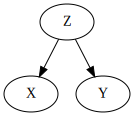

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("Z", "X"), ("Z", "Y")
    ],
)

Note. If $Z$ was the _only_ common cause, $X$ and $Y$ would be clones of one another. There are other non-modeled/unobserved influences of $X$ and $Y$--often referred to as error terms $e_{X,Y}$ that are not included in the graph above, but nonetheless are causing the difference between $X$ and $Y$, and should be modeled, often as noise  in any generative model.

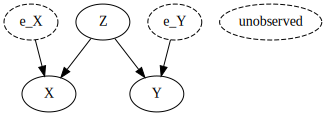

In [6]:
utils.draw_causal_graph(
    edge_list=[
        ("Z", "X"), ("Z", "Y"), ("e_X", "X"), ("e_Y", "Y")
    ],
    node_props={
        "e_X": {"style": "dashed"},
        "e_Y": {"style": "dashed"},
        "unobserved": {"style": "dashed"}   
    }
)

## Fork Generative Process: Discrete Example
Below we simulate a Fork generative process:

$$
\begin{align*}
Z &\sim \text{Bernoulli}(0.5) \\
X &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(p*) \\
p^* &= 0.9 \times Z + 0.1 \times (1 - Z) \\
\end{align*}
$$

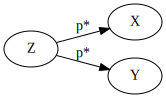

In [7]:
utils.draw_causal_graph(
    edge_list=[
        ("Z", "X"),
        ("Z", "Y")
    ],
    edge_props={
        ("Z", "X"): {"label": "p*"},
        ("Z", "Y"): {"label": "p*"}
    },
    graph_direction="LR"
)

In [8]:
# Discrete Fork
np.random.seed(321)
n_samples = 1000
Z = stats.bernoulli.rvs(p=.5, size=n_samples)
p_star = Z * .9 + (1 - Z) * .1
X = stats.bernoulli.rvs(p=p_star)
Y = stats.bernoulli.rvs(p=p_star)

Show that:
- $X \not\!\perp Y$
- $X \perp Y | Z$

In [9]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: 0.63
Cross tabulation:
     X    Y
X  412  101
Y   86  401

Correlation between X and Y conditioned on Z=0: -0.02
Cross tabulation:
     X   Y
X  407  49
Y   41   4

Correlation between X and Y conditioned on Z=1: -0.01
Cross tabulation:
    X    Y
X   5   52
Y  45  397


## Fork Generative Process: Continuous Example

$$
\begin{align*}
Z &\sim \text{Bernoulli}(0.5) \\
X &\sim \text{Normal}(Z, 1) \\
Y &\sim \text{Normal}(Z, 1) \\
\mu^* &= 2Z -1 \\
\end{align*}
$$

In [10]:
# Continous Fork
np.random.seed(1234)
n_samples = 400

Z = stats.bernoulli.rvs(p=.5, size=n_samples)

mu_star = 2 * Z - 1
X = stats.norm.rvs(loc=mu_star, size=n_samples)
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

# Put simulated data into dataframe for statsmodels API
fork_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

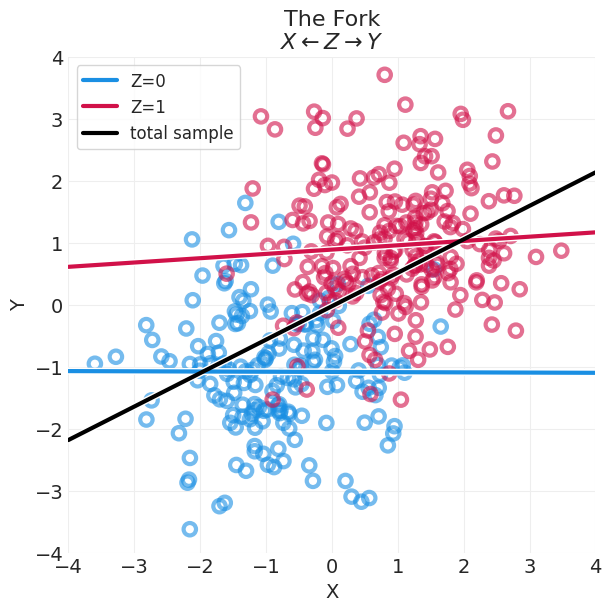

In [11]:
plot_continuous_confound_simulation(fork_data, "The Fork\n$X \\leftarrow Z \\rightarrow Y$")

## Fork Example: Marriage Rates & Divorce Rates (& Waffle House!)
🧇 As someone who grew up in the South, I love Wafflehouse, and by association, love this example.

In [12]:
import re
def plot_wafflehouse_pairwise(x_var, y_var, n_label=10, wafflehouse_divorce=WAFFLEHOUSE_DIVORCE):
    """Helper function for visualizing Wafflehouse data
    """
    # Scatter by South
    for south, label in enumerate([None, 'Southern\nStates']):
        xs = wafflehouse_divorce[wafflehouse_divorce['South'] == south][x_var].values        
        ys = wafflehouse_divorce[wafflehouse_divorce['South'] == south][y_var].values
        
        utils.plot_scatter(
            xs,
            ys,
            label=label,
            color=f'C{np.abs(south-1)}'  # Note: flip binary colorscale
        )
        
    # Annotate extreme values
    loc = wafflehouse_divorce['Loc'].tolist()
    
    xs = wafflehouse_divorce[x_var].values
    ys = wafflehouse_divorce[y_var].values
    xs_mean = np.mean(xs)
    ys_mean = np.mean(ys)
    
    def distance_from_center_of_mass(x, y):
        return (x - xs_mean) ** 2 + (y - ys_mean) ** 2
    
    sorted_xyl = sorted(
        zip(xs, ys, loc),
        key=lambda z: distance_from_center_of_mass(z[0], z[1])
    )[::-1]
    
    for li in range(n_label):
        x, y, label = sorted_xyl[li]
        plt.annotate(label, (x + .1, y + .1))

    def camelcase_to_label(string):
        return re.sub(r'(?<!^)(?=[A-Z])', ' ', string).lower()

    plt.xlabel(camelcase_to_label(x_var))
    plt.ylabel(camelcase_to_label(y_var))

    plt.legend();

### Marying the Owl
1. Estimand
2. Scientific Model
3. Statistical Model
4. Analysis

### (1) Estimand
Causal effect of **Marriage** Rate, M on **Divorce** Rate, D


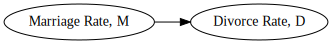

In [13]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "D")
    ],
    node_props={
        "M": {"label": "Marriage Rate, M"},
        "D": {"label": "Divorce Rate, D"}
    },
    graph_direction="LR"
)

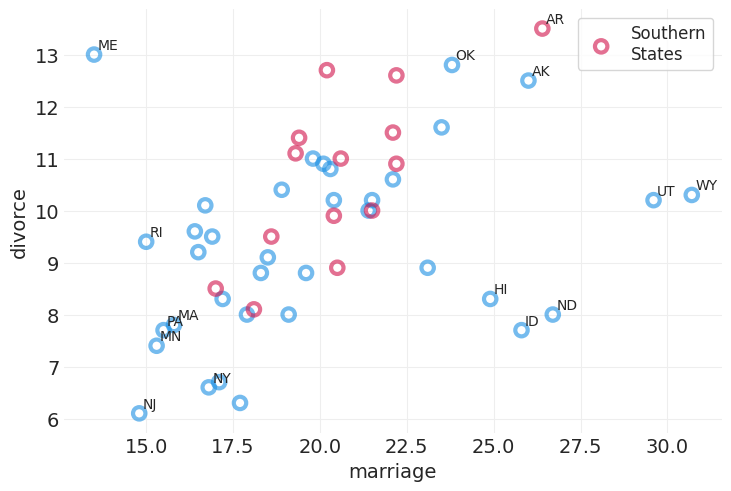

In [14]:
plot_wafflehouse_pairwise('Marriage', 'Divorce', n_label=15)

...another potential cause is **Age at Marriage**

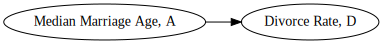

In [15]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "D")
    ],
    node_props={
        "A": {"label": "Median Marriage Age, A"},
        "D": {"label": "Divorce Rate, D"}
    },
    graph_direction="LR"
)

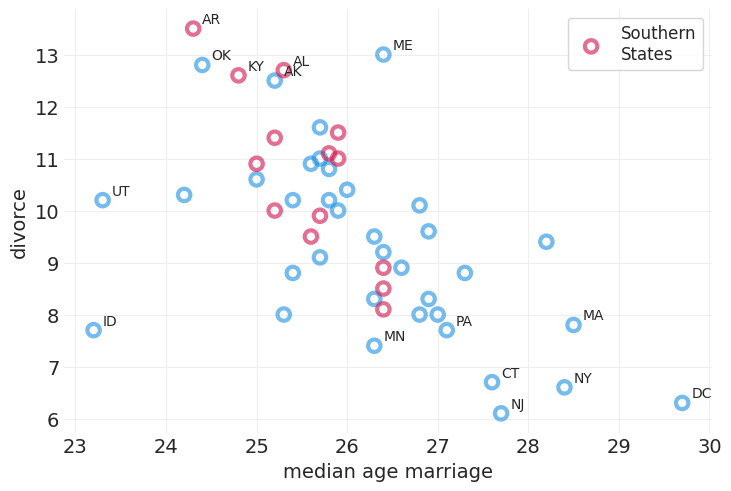

In [16]:
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Divorce', n_label=15)

### (2) Scientific Model

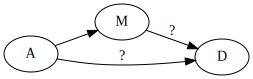

In [17]:
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"),
        ("A", "M"),
        ("A", "D")
    ],
    edge_props={
        ("A", "D"): {"label": " ?"},
        ("M", "D"): {"label": " ?"}
    },
    graph_direction="LR"
)

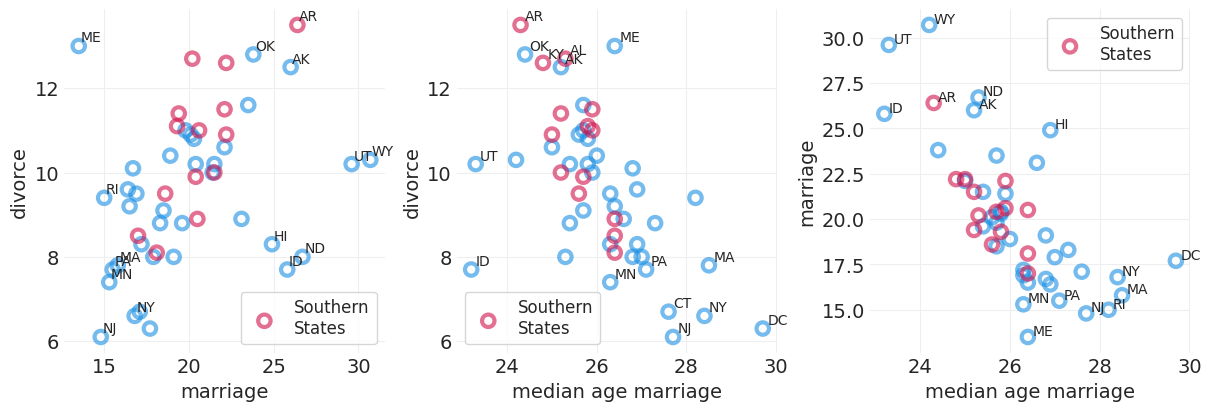

In [18]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axs[0])
plot_wafflehouse_pairwise('Marriage', 'Divorce', n_label=15)

plt.sca(axs[1])
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Divorce', n_label=15)

plt.sca(axs[2])
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Marriage', n_label=15)

- **Is the effect of Marriage rate on Divorce rate solely the result of their common cause Age--i.e. the Fork?**
  - Can't tell from just looking at the scatter plots above.
- We need to **break the Fork by stratifying by Age**

#### Testing Scientific Model with Generative Process Model
> Notes: 
> - McElreath mentions that we should always do this testing step in the standard analysis pipeline, but skips for sake of time, so we do go ahead and take a stab at it here.
> - this simulation models the Marriage Process as a function of Age, and Divorce as a function of Age _and_ Marriage
> - this simulation is in the space of standardized predictor variables

### Stratifying by a continuous variable

$$
\begin{align*}
D &= f(A, M) \\
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_M M_i + \beta_A A_i \\
\mu_i &= (\alpha + \beta_A A_i) + \beta_M M_i 
\end{align*}
$$

where $(\alpha + \beta_A A_i)$  can be thought of as an effective intercept for each continuous value of $A$


### Generating data according to the statistical model

### Statistical Fork

$$
\begin{align*}
D &= f(A, M) \\
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_M M_i + \beta_A A_i \\
\alpha &\sim \text{Normal}(\mu_?, \sigma_?) \\
\beta_{A, M} &\sim \text{Normal}(\mu_?, \sigma_?) \\
\sigma &\sim \text{Exponential}(\lambda_?)
\end{align*}
$$

What parameters $\theta_?$  do we use for the priors? **Enter Prior Predictive Simulation**

#### 💡 When working with Linear Regression, it's always always a good idea to **standardize**
- $X_{standardized} = \frac{(X - \bar X)}{\bar \sigma}$
- $\bar X$ and $\bar \sigma$ are the sample mean and standard deviation
- results in a mean of 0 and standard deviation of 1
- simplifies prior definition
- makes inference run smoother
- can always reverse the standarization transformation (using $\bar X$ and $\bar \sigma$) to get back to the original space

### Prior Predictive Simulation
Gives us better intuition of the types of lines the model can produce given a set of prior parameters

In [19]:
def simulate_linear_model_priors(std=10, n_simulations=200):

    xs = np.linspace(-3, 3, 10)
    for ii in range(n_simulations):
        alpha = stats.norm.rvs(0, std)
        beta = stats.norm.rvs(0, std)
        ys = alpha + beta * xs
        plt.plot(xs, ys, color='C0', alpha=.25)
    
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel("median age at marriage (standardized)")
    plt.ylabel("Divorce rate (standardized)")

In [20]:
xs = np.linspace(-3, 3, 10)
# for ii in range(n_simulations):
#     alpha = stats.norm.rvs(0, std)
#     beta = stats.norm.rvs(0, std)
#     ys = alpha + beta * xs
#     plt.plot(xs, ys, color='C0', alpha=.25)
    
xs

array([-3.        , -2.33333333, -1.66666667, -1.        , -0.33333333,
        0.33333333,  1.        ,  1.66666667,  2.33333333,  3.        ])

#### Too large of a prior variance results in unrealistic linear models

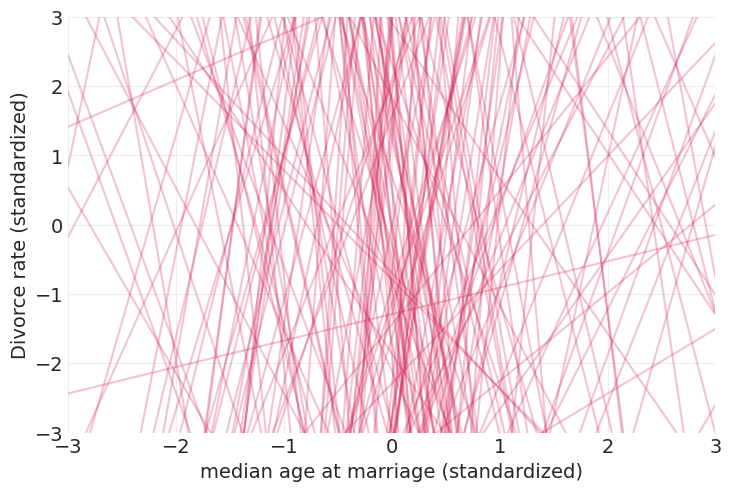

In [20]:
simulate_linear_model_priors(std=10)

#### More reasonable priors for standardized variables

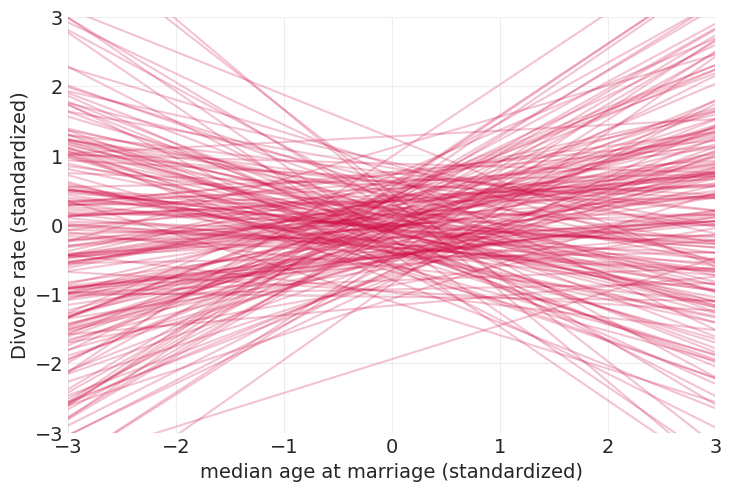

In [21]:
simulate_linear_model_priors(std=.5)

 ### (3) Statistical Model for Causal Effect of Marriage on Divorce

Here's the full statistical model with more reasonable priors.

$$
\begin{align*}
D &= f(A, M) \\
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_M M_i + \beta_A A_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_{A, M} &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$
where we've standardized all the input variable such that we can use standard normal for all intercept/slope parmaeter priors

#### Run the statistical model on the simulated data
Verify that we can recover the parameters from a generative process that matches the statistical model

In [21]:
def simulate_divorce(
    beta_marriage_divorce=1,
    beta_age_divorce=-1,
    beta_age_marriage=0,
    alpha=0.0,
    sigma=0.5,
    random_seed=123
):
    N_STATES = 50
    np.random.seed(random_seed)
    
    # Age (standardized)
    age = stats.norm.rvs(size=N_STATES)
    
    # Marriage rate
    marriage_rate = 0
    if beta_marriage_divorce != 0:
        marriage_rate = age * beta_age_marriage + stats.norm(0, sigma).rvs(size=N_STATES)
    
    # Divorce Rate
    mu = alpha + marriage_rate * beta_marriage_divorce + age * beta_age_divorce
    divorce_rate = stats.norm.rvs(mu, sigma)
    
    simulated_divorce = pd.DataFrame(
        {
            "MedianAgeMarriage": age,
            "Marriage": marriage_rate,
            "Divorce": divorce_rate
        }
    )
    
    # Shuffle actual labels to retain same proportion of Southern/Other states
    # i.e. Southern state has no effect on parameters in this simulation
    simulated_location = WAFFLEHOUSE_DIVORCE[['Loc', "South"]].sample(frac=1.0)
    simulated_divorce.loc[:, ['Loc', 'South']] = simulated_location
    return simulated_divorce

In [22]:
MARRIAGE_DIVORCE_SIMULATION_PARAMS = dict(
    beta_marriage_divorce=1,
    beta_age_divorce=-1,
    beta_age_marriage=0,
    alpha=0,
    sigma=0.5
)
SIMULATED_MARRIAGE_DIVORCE = simulate_divorce(**MARRIAGE_DIVORCE_SIMULATION_PARAMS, random_seed=1)

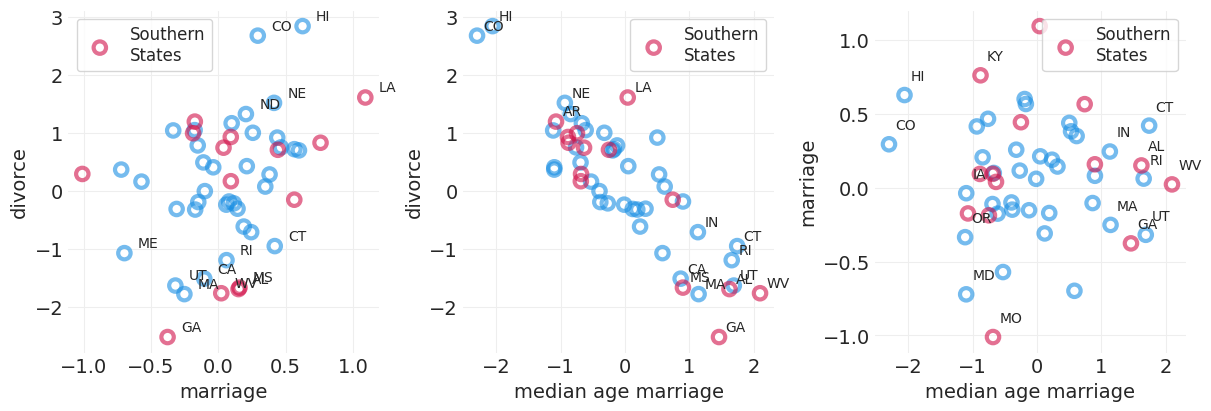

In [23]:
# Plot simulation
_, axs = plt.subplots(1, 3, figsize=(12, 4))

plt.sca(axs[0])
plot_wafflehouse_pairwise('Marriage', 'Divorce', n_label=15, wafflehouse_divorce=SIMULATED_MARRIAGE_DIVORCE)

plt.sca(axs[1])
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Divorce', n_label=15, wafflehouse_divorce=SIMULATED_MARRIAGE_DIVORCE)

plt.sca(axs[2])
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Marriage', n_label=15, wafflehouse_divorce=SIMULATED_MARRIAGE_DIVORCE)

In [24]:
MARRIAGE_DIVORCE_MODEL_PARAMS = ["alpha", "beta_marriage", "beta_age",  "sigma"]

def fit_marriage_divorce_model(data):
    with pm.Model() as divorce_model:

        # Observed Data
        age = pm.MutableData(
            "age", data["MedianAgeMarriage"].values, dims="obs_ids"
        )
        marriage_rate = pm.MutableData(
            "marriage_rate", data["Marriage"].values, dims="obs_ids"
        )
        divorce_rate = data["Divorce"].values

        sigma = pm.Exponential("sigma", 1)
        alpha = pm.Normal("alpha", 0, 0.2)
        beta_age = pm.Normal("beta_age", 0, 1)
        beta_marriage = pm.Normal("beta_marriage", 0, 1)

        ## Divorce process
        mu = alpha + beta_marriage * marriage_rate + beta_age * age
        pm.Normal(
            "divorce_rate",
            mu,
            sigma,
            observed=divorce_rate,
            dims="obs_ids"
        )
        divorce_inference = pm.sample(10000, target_accept=.95)
    return divorce_model, divorce_inference

def plot_divorce_model_posterior(
    inference,
    model_params,
    actual_params=None,
    ax=None
):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 2))

    plt.sca(ax)
    pm.plot_forest(
        inference,
        var_names=model_params,
        combined=True,
        ax=ax
    )
    title = "Posterior"
    if actual_params is not None:
        for param in actual_params:
            plt.axvline(param, color='k', linestyle='--')
        title += " and\nActual Parameter Values"
    plt.title(title)

In [25]:
simulated_marriage_divorce_model, simulated_marriage_divorce_inference = fit_marriage_divorce_model(SIMULATED_MARRIAGE_DIVORCE)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta_age, beta_marriage]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [27]:
pm.summary(
    simulated_marriage_divorce_inference,
    var_names=MARRIAGE_DIVORCE_MODEL_PARAMS
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.044,0.063,-0.071,0.167,0.000,0.000,45026.0,29069.0,1.0
beta_marriage,0.928,0.162,0.630,1.236,0.001,0.001,44163.0,28683.0,1.0
beta_age,-0.979,0.068,-1.106,-0.851,0.000,0.000,43787.0,26239.0,1.0
sigma,0.458,0.048,0.371,0.549,0.000,0.000,42797.0,28793.0,1.0


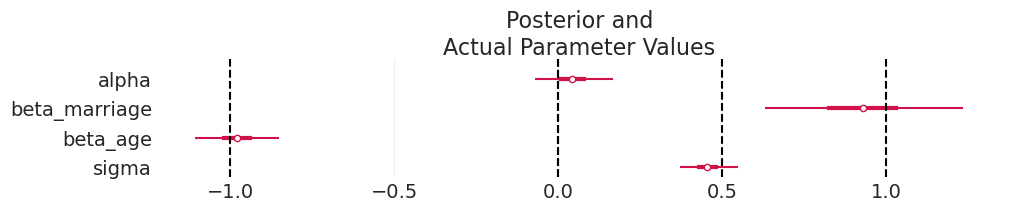

In [28]:
plot_divorce_model_posterior(
    simulated_marriage_divorce_inference,
    model_params=MARRIAGE_DIVORCE_MODEL_PARAMS,
    actual_params=MARRIAGE_DIVORCE_SIMULATION_PARAMS.values()
)

cool. We can recover our params with this model. Let's try it on real data.

In [29]:
# Generate a standardized version of the real data
WAFFLEHOUSE_DIVORCE_STD = WAFFLEHOUSE_DIVORCE.copy()

# standardize variables
for var in ["MedianAgeMarriage", "Marriage", "Divorce"]:
    WAFFLEHOUSE_DIVORCE_STD.loc[:, var] = utils.standardize(WAFFLEHOUSE_DIVORCE_STD[var])

In [30]:
marriage_divorce_model, marriage_divorce_inference = fit_marriage_divorce_model(WAFFLEHOUSE_DIVORCE_STD)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_age, beta_marriage]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


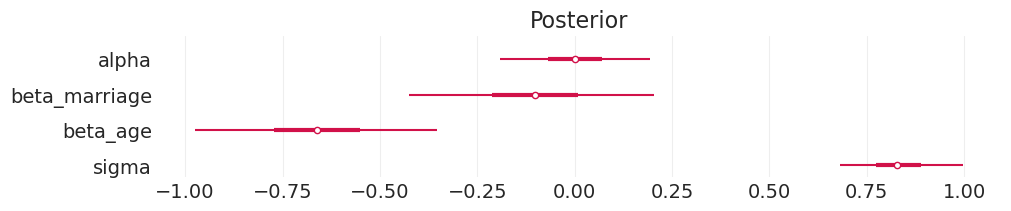

In [31]:
plot_divorce_model_posterior(marriage_divorce_inference, model_params=MARRIAGE_DIVORCE_MODEL_PARAMS)

### Simulating Interventions

#### Causal Effect of Marriage Rate on Divorce Rate

#### No intervention

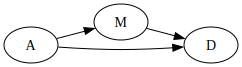

In [32]:
# Without Interventions
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"),
        ("A", "M"),
        ("A", "D")
    ],
    graph_direction="LR"
)

#### $do(M)$
- We "play God" by setting the value of $M$
- Deletes the arrow entering $M$
  - thus breaks the associating $A$ and

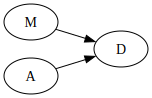

In [33]:
# With Interventions do(M)
utils.draw_causal_graph(
    edge_list=[
        ("M", "D"), 
        ("A", "D")
    ],
    graph_direction="LR"
)

Now we simulate two worlds where $M$ takes on very different values (e.g. 0 and +1 std) to identify the possible range of causal effects of Marriage on Age. In principle, we could do this for any number of values along the continuum of $M$

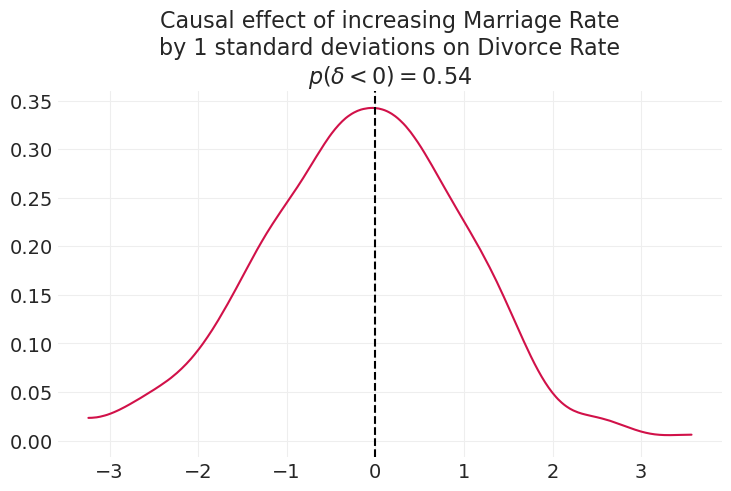

In [34]:
np.random.seed(123)
n_simulations = int(1e3)
posterior = marriage_divorce_inference.posterior.sel(chain=0)

# Sample Ages
age_samples = stats.norm.rvs(0, 1, size=n_simulations)

# Sample parameters from posterior
alpha_samples = np.random.choice(posterior.alpha, size=n_simulations, replace=True)
sigma_samples = np.random.choice(posterior.sigma, size=n_simulations, replace=True)
beta_age_samples = np.random.choice(posterior.beta_age, size=n_simulations, replace=True)
beta_marriage_samples = np.random.choice(posterior.beta_marriage, size=n_simulations, replace=True)

marriage_contrast = {}
n_std_increase = 1
for do_marriage in [0,  n_std_increase]:  # Playing God, setting the value of Marriage Rate
    mu = alpha_samples + beta_age_samples * age_samples + beta_marriage_samples * do_marriage
    marriage_contrast[do_marriage] = stats.norm.rvs(mu, sigma_samples)

marriage_contrast = marriage_contrast[n_std_increase] - marriage_contrast[0]
prob_lt_zero = (marriage_contrast < 0).mean()
az.plot_dist(marriage_contrast)
plt.axvline(0, color='k', linestyle='--');
plt.title(
    "Causal effect of increasing Marriage Rate\n"
    f"by {n_std_increase} standard deviations on Divorce Rate\n"
    f"$p(\delta < 0) = {prob_lt_zero:1.2}$"
);

But that's just one slice of the Marriage range. We can use pymc to look at the causal effect of shifting Age over a range of values.

In [35]:
marriage_counterfactuals = xr.DataArray(np.linspace(-3, 3, 100))
age_counterfactuals = xr.DataArray(np.zeros_like(marriage_counterfactuals))  # set all to average age
with marriage_divorce_model:
    pm.set_data({"marriage_rate": marriage_counterfactuals, "age": age_counterfactuals})
    ppd_marriage_divorce = pm.sample_posterior_predictive(marriage_divorce_inference, extend_inferencedata=False)

Sampling: [divorce_rate]


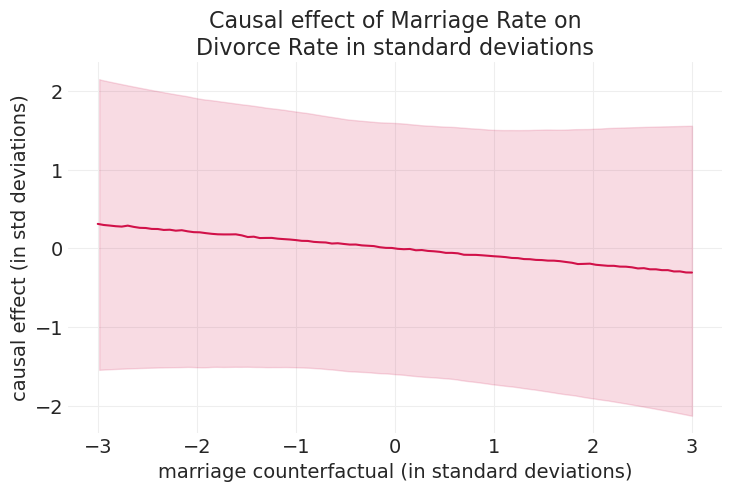

In [36]:
az.plot_hdi(
    marriage_counterfactuals,
    ppd_marriage_divorce.posterior_predictive["divorce_rate"],
    color="C0", fill_kwargs={"alpha": .15}
)
plt.plot(
    marriage_counterfactuals,
    ppd_marriage_divorce.posterior_predictive["divorce_rate"].mean(dim=("chain", "draw")),
    color="C0"
)
plt.xlabel("marriage counterfactual (in standard deviations)")
plt.ylabel("causal effect (in std deviations)")
plt.title("Causal effect of Marriage Rate on\nDivorce Rate in standard deviations");

## Causal Effect of Age on Divorce Rate?
- how do we do implement $do(A)$?
- There are no causal arrows that we need to remove for an intervention
- **This requires a new model that ignores $M$**
  - we can then simulate any intervention on $A$
- Why can we ignore $M$?
  - because $A \rightarrow M \rightarrow D$ is **a Pipe**


## The Pipe $X \rightarrow Z \rightarrow Y$


- $Z$ is a "mediator" of $Χ$ and $Y$ ($Z$ does not affect $X$)
- The influence of $Χ$ on $Y$ is transmitted through $Z$, thus $X$ and $Y$ are associated
  - $X \not \perp Y$
- once stratified by $Z$, no association between $Χ$ and $Y$ **for each level of $Z$**
  -  $X \perp Y | Z$

- **Statistically very similar to the Fork**
- **Causally very different from the Fork**

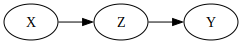

In [37]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y")
    ],
    graph_direction="LR"
)

## Discrete Example

Below we simulate a "Pipe" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
Y &\sim \text{Bernoulli}(q*) \\
p^* &= 0.9 X + 0.1 (1 - X) \\
q^* &= 0.9 Z + 0.1 (1 - Z) \\
\end{align*}
$$

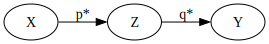

In [38]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "Y")
    ],
    edge_props={
        ("X", "Z"): {"label": "p*"},
        ("Z", "Y"): {"label": "q*"}
    },
    graph_direction="LR"
)

In [39]:
np.random.seed(1234)
n_samples = 1000
X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = X * .9 + (1 - X) * .1
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = Z * .9 + (1 - Z) * .1
Y = stats.bernoulli.rvs(p=q_star, size=n_samples)

Demonstrate that:
- $X \not \perp Y$
- $X \perp Y | Z$

In [40]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: 0.65
Cross tabulation:
     X    Y
X  396   84
Y   89  431

Correlation between X and Y conditioned on Z=0: -0.02
Cross tabulation:
     X   Y
X  392  46
Y   41   4

Correlation between X and Y conditioned on Z=1: -0.01
Cross tabulation:
    X    Y
X   4   38
Y  48  427


### Why does this happen?
 - everything $X$ knows about $Y$, $Z$ knows
 - once you learn about $Z$, there is nothing else to learn about the association between $X$ and $Y$

## Continuous Example

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p^*) \\
Y &\sim \text{Normal}(\mu^*, 1) \\
p^* &= \frac{1}{1 + e^{-X}} \\
\mu^* &= 2Z - 1 \\
\end{align*}
$$

In [41]:
np.random.seed(1234)
n_samples = 1000

X = stats.norm.rvs(size=n_samples)
p_star = utils.invlogit(X)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

mu_star = 2 * Z - 1
Y = stats.norm.rvs(loc=mu_star, size=n_samples)

pipe_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

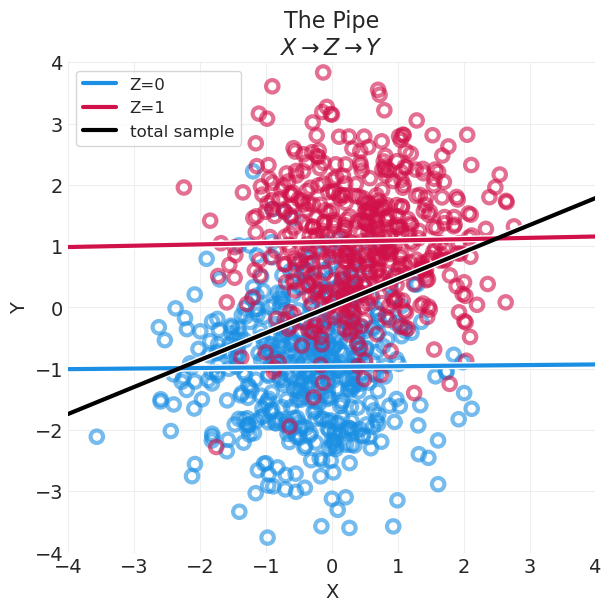

In [42]:
plot_continuous_confound_simulation(pipe_data, "The Pipe\n$X \\rightarrow  Z \\rightarrow Y$")

### Pipe Example: Plant Growth

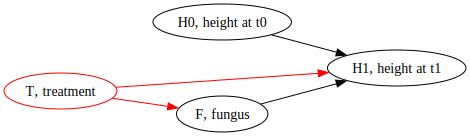

In [43]:
utils.draw_causal_graph(
    [
        ("H0", "H1"),
        ("T", "H1"),
        ("T", "F"),
        ("F", "H1")
    ],
    node_props={
        "T": {"color": "red", "label": "T, treatment"},
        "F": {"label": "F, fungus"},
        "H0": {"label": "H0, height at t0"},
        "H1": {"label": "H1, height at t1"}
    },
    edge_props={
        ("T", "H1"): {"color": "red"},
        ("T", "F"): {"color": "red"},
    },
    graph_direction="LR"
)

### To estimate the **Total Causal Effect** of Treatment, should we Stratify by F?

**NO**
- Stratifying by F would be a bad idea here if we wanted to estimate the total causal effect of T on H1, because of the $T \rightarrow F \rightarrow H1$ pipe in the graph.
- Stratifying by F would block infromation about T's affect on H1 that flow through F. 
- NOTE: stratifying by $F$ would give the **Direct Causal Effect** of $T$ on $H1$

This is an example of **post-treatment bias**.
> Rule of Thumb: **consequence of the treatement should not be included in an estimator.**

### Statistical Model for Causal Effect of Age on Divorce Rate
McElreath meantions how we could/should build and test this model, but doesn't do this in the lecture, so we do it here! 

The Age-Divorce model is similar to the Marriage-Divorce model, but we no longer need to stratify by Marriage.

$$
\begin{align*}
D &= f(A, M) \\
D_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_A A_i \\
\alpha &\sim \text{Normal}(0, 0.2) \\
\beta_A &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [44]:
AGE_DIVORCE_MODEL_PARAMS = ["sigma", "alpha", "beta_age"]
def fit_age_divorce_model(data):
    with pm.Model() as divorce_model:

        # Observed Data
        age = pm.MutableData(
            "age", data["MedianAgeMarriage"].values, dims="obs_ids"
        )

        alpha = pm.Normal("alpha", 0, 0.2)
        beta_age = pm.Normal("beta_age", 0, 1)
        sigma = pm.Exponential("sigma", 1)

        ## Divorce process
        mu = alpha + beta_age * age
        pm.Normal(
            "divorce_rate",
            mu,
            sigma,
            observed=data["Divorce"].values,
            dims="obs_ids"
        )
        divorce_inference = pm.sample(10000, target_accept=.95)
    return divorce_model, divorce_inference

### Test Age-Divorce model on simulated data

In [45]:
AGE_DIVORCE_SIMULATION_PARAMS = dict(
    beta_age_divorce=-1.,
    sigma=.5,
    alpha=0.,
    beta_marriage_divorce=0,
    beta_age_marriage=0
)
SIMULATED_AGE_DIVORCE = simulate_divorce(**AGE_DIVORCE_SIMULATION_PARAMS)

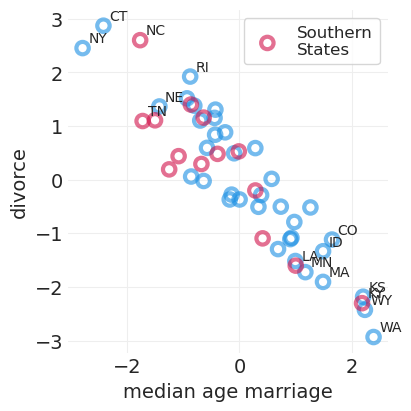

In [46]:
# Plot simulation
plt.subplots(figsize=(4, 4))
plot_wafflehouse_pairwise('MedianAgeMarriage', 'Divorce', n_label=15, wafflehouse_divorce=SIMULATED_AGE_DIVORCE)

In [47]:
simulated_age_divorce_model, simulated_age_divorce_inference = fit_age_divorce_model(SIMULATED_AGE_DIVORCE)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


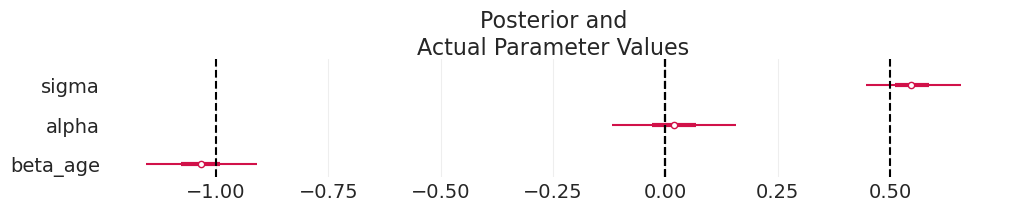

In [48]:
plot_divorce_model_posterior(
    simulated_age_divorce_inference,
    model_params=AGE_DIVORCE_MODEL_PARAMS,
    actual_params=AGE_DIVORCE_SIMULATION_PARAMS.values()
)

# 🤘
We can recover the simulation params.

### Fit Age-Divorce model on real data

In [49]:
age_divorce_model, age_divorce_inference = fit_age_divorce_model(WAFFLEHOUSE_DIVORCE_STD)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_age, sigma]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 4 seconds.


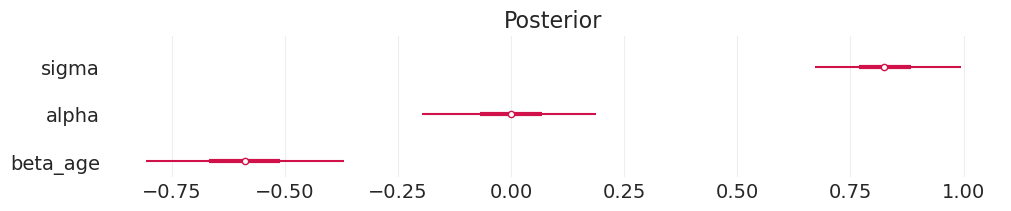

In [50]:
plot_divorce_model_posterior(
    age_divorce_inference,
    model_params=AGE_DIVORCE_MODEL_PARAMS
)

### Run Age Counterfactuals

In [51]:
age_counterfactuals = xr.DataArray(np.linspace(-3, 3, 100))

with age_divorce_model:
    pm.set_data({"age": age_counterfactuals})
    ppd_age = pm.sample_posterior_predictive(age_divorce_inference, extend_inferencedata=False)

Sampling: [divorce_rate]


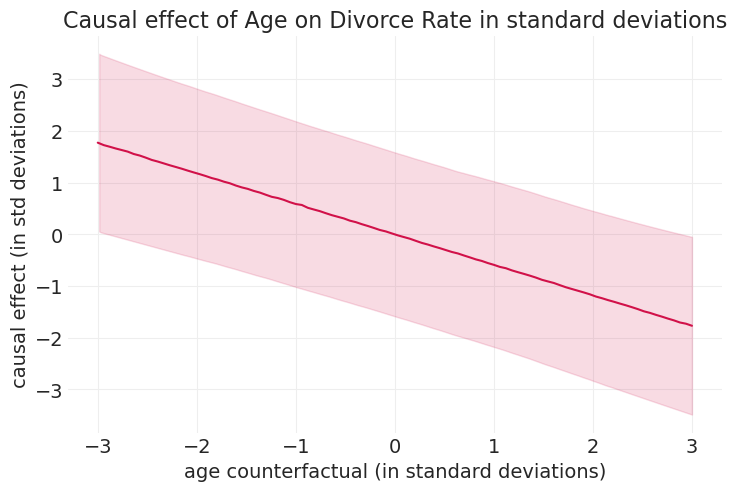

In [52]:
az.plot_hdi(
    age_counterfactuals, 
    ppd_age.posterior_predictive["divorce_rate"],
    color="C0", fill_kwargs={"alpha": .15}
)
plt.plot(
    age_counterfactuals,
    ppd_age.posterior_predictive["divorce_rate"].mean(dim=("chain", "draw")),
    color="C0"
)
plt.xlabel("age counterfactual (in standard deviations)")
plt.ylabel("causal effect (in std deviations)")
plt.title("Causal effect of Age on Divorce Rate in standard deviations");

## The Collider $X \rightarrow Z \leftarrow Y$


- $Z$ _caused jointly_ by $Χ$ and $Y$
- $X$ and $Y$ have no shared causes, thus are not associated
  - $X \perp Y$
- once stratified by $Z$, $Χ$ and $Y$ are now associated
  -  $X \not \perp Y | Z$
  -  stratifying by $Z$ provides information about $X$ and $Y$


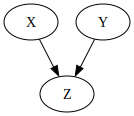

In [53]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Y", "Z")
    ]
)

## Discrete Example

Below we simulate a "Collider" generative process:

$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Y &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p*) \\
p^* &= \begin{cases}
    0.9 ,& \text{if } X + Y \gt 0\\
    0.05,              & \text{otherwise}
\end{cases}
\end{align*}
$$


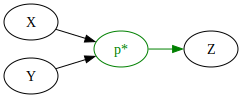

In [54]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "p_star"),
        ("Y", "p_star"),
        ("p_star", "Z")
    ],
    node_props={"p_star": {"label": "p*", "color": "green", "fontcolor": "green"}},
    edge_props={("p_star", "Z"): {"color": "green"}},
    graph_direction="LR"
)

Note: the structure above should not be confused with the "Descendant" discussed later. Here $p^*$ is a determinstic function of $X$ and $Y$ that defines the probability distribution over $Z$, wheras in the Descendant, the  downstream variable (e.g. $A$) "leaks" information about the collider.

In [55]:
np.random.seed(123)
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)
Y = stats.bernoulli.rvs(p=.5, size=n_samples)

# p(z | x, y)
p_star = np.where(X + Y > 0, 0.9, 0.05)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

Demonstrate that:
- $X \perp Y$
- $X \not  \perp Y | Z$

In [56]:
summarize_discrete_counfound_simulation(X, Y, Z)

Correlation between X and Y: -0.052
Cross tabulation:
     X    Y
X  240  268
Y  258  234

Correlation between X and Y conditioned on Z=0: 0.41
Cross tabulation:
     X   Y
X  229  21
Y   23  22

Correlation between X and Y conditioned on Z=1: -0.49
Cross tabulation:
     X    Y
X   11  247
Y  235  212


## Continuous Example

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
Y &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p*) \\
p^* &= \frac{1}{1 + e^{-(\alpha + \beta_{XZ}X + \beta_{YZ}Y)}} \\
\end{align*}
$$

In [57]:
np.random.seed(1234)

n_samples = 500
X = stats.norm.rvs(size=n_samples)
Y = stats.norm.rvs(size=n_samples)

beta_XZ = 2
beta_YZ = 2
alpha = -2

p_star = utils.invlogit(alpha + beta_XZ * X + beta_YZ * Y)
Z = stats.bernoulli.rvs(p=p_star)

collider_data = pd.DataFrame(np.vstack([Z, X, Y]).T, columns=['Z', 'X', 'Y'])

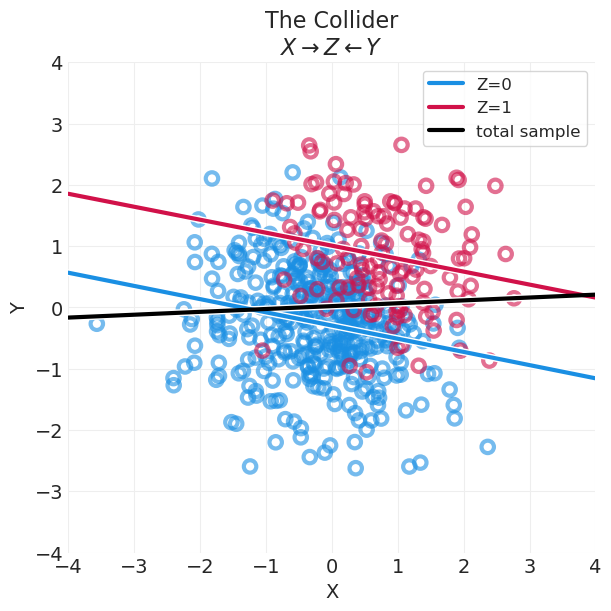

In [58]:
plot_continuous_confound_simulation(collider_data, "The Collider\n$X \\rightarrow  Z \\leftarrow Y$")

- Total sample shows no association
- Stratifying by Z shows negative association

### Why does this happen?

**Thresholding effect**
- If either $X$ OR $Y$ are big enough, it will result in a conditional value (the green deterministic function $p*$ above) that is large enough to associate the sample with $Z=1$.
- Similarly if either $X$ OR $Y$ are small enough, it will associate the sample with $Z=0$.
- If one of those is is hi/low enough while the other is average or lower/larger, this will induce a negative correlation on average.

## Collider Example: Grant Awards
$N \rightarrow A \leftarrow T$
- To be awarded $A$, Grants must be sufficiently either Newsworthy $N$ or Trustworthy $T$
- Few grants are high on both
- results in negative association for awarded grants
- Post-selection bias

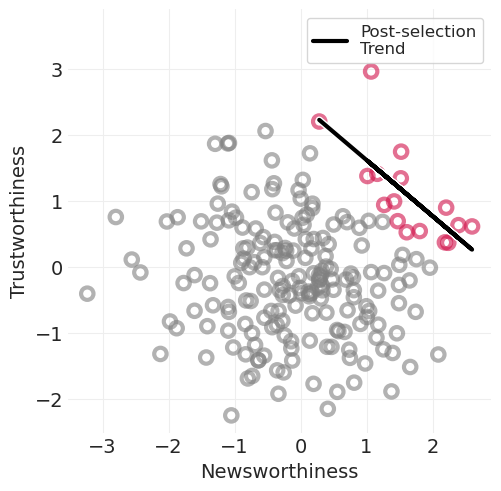

In [59]:
np.random.seed(123)
n_samples = 200

# N and T are independent
N = stats.norm.rvs(size=n_samples)
T = stats.norm.rvs(size=n_samples)

# Award criterion; either are large enough to threshold
A = np.where(N + T > 2, 1, 0)

for awarded in [0, 1]:
    color = 'gray' if not awarded else 'C0'
    N_A = N[A==awarded]
    T_A = T[A==awarded]
    utils.plot_scatter(N_A, T_A, color=color)

awarded_model = smf.ols("T ~ N", data=pd.DataFrame({"N": N_A, "T": T_A})).fit()
utils.plot_line(N_A, awarded_model.predict(), color='k', label='Post-selection\nTrend')
plt.xlabel("Newsworthiness")
plt.ylabel("Trustworthiness")
plt.axis("square")
plt.legend();

## Example: Age, Happiness, and Marriage

$A \rightarrow M \leftarrow H$

- The older you are, the more changes of being married
- The happier you are, the more amicable you are, and thus are more likely to have another person marry you
- Here, **age does not influence happiness**, they are independent

Below is a janky version of the simulation in the lecture. Rather than running the termporal simulation, starting at age 18, 
and sampling marital status for each happiness level at each point in time, we just do the whole simulation in one sample, modeling the probability of being married as a combination of both Age $A$ and Happiness $H$: $p_{married} = \text{invlogit}(\beta_H (\bar H - 18) + \beta_A A)$

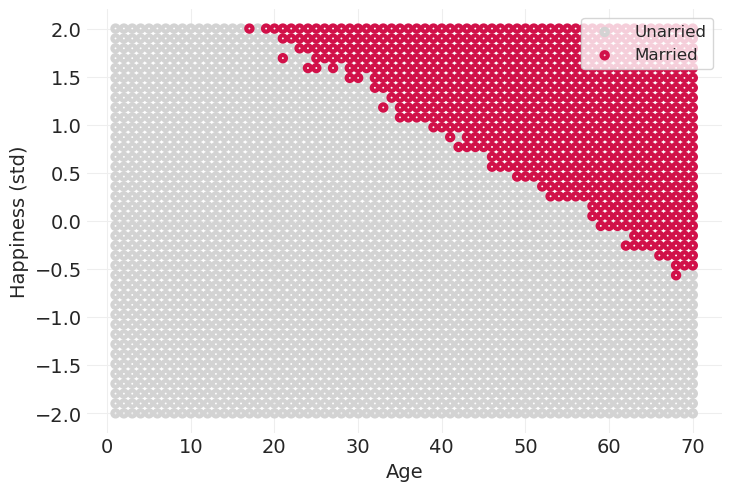

In [60]:
age = np.arange(1, 71) 
happiness = np.linspace(-2, 2, 40)
age_grid, happiness_grid = np.meshgrid(age, happiness)

# Arbitrary
beta_happiness = 20
beta_age = 1
min_marriage_age = 18

age_grid = age_grid.ravel() 
happiness_grid = happiness_grid.ravel()
married_grid = []
for a, h in zip(age_grid, happiness_grid):
    p_marriage = utils.invlogit(h * beta_happiness + (a - 40 - 18) * beta_age)
    married_grid.append(stats.bernoulli(p=p_marriage).rvs())
    
married_grid = np.array(married_grid).astype(int)

utils.plot_scatter(age_grid[married_grid==0], happiness_grid[married_grid==0], s=20, alpha=1, color='lightgray', label='Unarried')
utils.plot_scatter(age_grid[married_grid==1], happiness_grid[married_grid==1], s=20, alpha=1, color='C0', label='Married')
plt.xlabel("Age")
plt.ylabel("Happiness (std)")
plt.legend();


If we were to stratify by married folks only ($M=1$), we would conclude that Age and Happiness are negatively associated, despite them actually being independent in this simulation.

## Collider Example: Restaurant Success

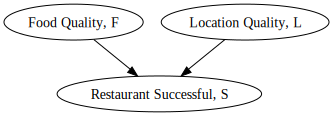

In [61]:
utils.draw_causal_graph(
    edge_list=[
        ("F", "S"),
        ("L", "S")
    ],
    node_props={
        "F": {"label": "Food Quality, F"},
        "L": {"label": "Location Quality, L"},
        "S": {"label": "Restaurant Successful, S"}
    }
)

#### Simulate Restaurant Success

$$
\begin{align*}
S &\sim \text{Bernoulli}(p_S) \\
p_S &= \text{invlogit}(\alpha+ \beta_Q Q + \beta_L L) \\
\end{align*}
$$

In [62]:
np.random.seed(123)
n_restaurants = 1000
food_quality = stats.norm.rvs(size=n_restaurants)  # standardized food quality
location_quality = stats.norm.rvs(size=n_restaurants)  # standardized quality of restaurant location

beta_food_quality = 20  # good food increases probability of success
beta_location_quality = 20  # good location also increases probability of success
intercept = -40  # the average restaurant will not succeed

p_success = utils.invlogit(
    food_quality * beta_food_quality + location_quality * beta_location_quality + intercept
)  
stays_in_business = stats.bernoulli.rvs(p_success)

data = data = pd.DataFrame(
    np.vstack(
        [location_quality, food_quality, stays_in_business]
    ).T,
    columns=['location_quality', 'food_quality', 'stays_in_business']
)

In [63]:
models = {}
models['unstratified'] = smf.ols("food_quality ~ location_quality", data=data).fit()

# Stratified Models (post-hoc selection based on successful business)
models['business_failed'] = smf.ols("food_quality ~ location_quality", data=data[data.stays_in_business==0]).fit()
models['business_succeeded'] = smf.ols("food_quality ~ location_quality", data=data[data.stays_in_business==1]).fit()


In [64]:
def plot_sms_restaurant_model_fit(model, xs, label, color):
    """Helper function to plot linear models"""
    params = model.params
    ys = params.Intercept + params.location_quality * xs
    return utils.plot_line(xs, ys, label=label, color=color)

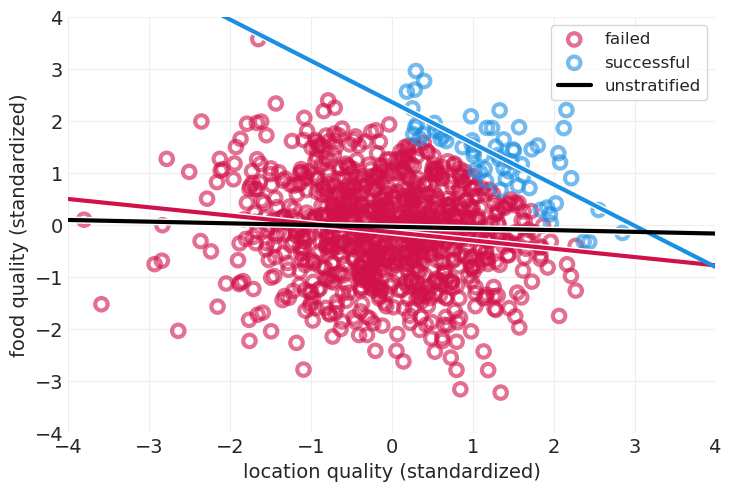

In [65]:
xs = np.linspace(-4, 4, 20)

for sib, label in enumerate(["business_failed", "business_succeeded"]):
    scatter_data = data[data.stays_in_business==sib]
    utils.plot_scatter(
        scatter_data.location_quality,
        scatter_data.food_quality,
        color=f'C{sib}',
        label="successful" if sib else "failed"
    );
    
    plot_sms_restaurant_model_fit(models[label], xs, color=f'C{sib}', label=None)

plot_sms_restaurant_model_fit(models['unstratified'], xs, label='unstratified', color='black')

plt.xlabel("location quality (standardized)")
plt.ylabel("food quality (standardized)")

plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.legend();

By looking only at successful restaurants, we would mislead ourselves and infer that lower-quality locations have better food, when in fact there is no relationship between location and food quality.

## The Decendent
Takes on a diluted behavior of the parent. 
- If the parent forms a Collider, the descendant acts as a weak collider. Same for Pipe and Fork descendants

## Discrete Example: Pipe Descendant
In this example the descendant branches off of a Pipe. Therefore we should observe the following:
- $X \not \perp Y$
- $X \perp Y | Z$
- $X \not \perp Y | A$, but correlation between X and Y should be reduced

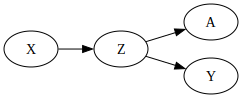

In [66]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Z", "Y")
    ],
    graph_direction="LR"
)


$$
\begin{align*}
X &\sim \text{Bernoulli}(0.5) \\
Z &\sim \text{Bernoulli}(p^*) \\
A &\sim \text{Bernoulli}(q^*) \\
Y &\sim \text{Bernoulli}(r^*) \\
p^* &= 0.9 X + 0.1 (1 - X) \\
q^* &= 0.9 Z + 0.1 (1 - Z) \\
r^* &= 0.9 Z + 0.1 (1 - Z) \\
\end{align*}
$$


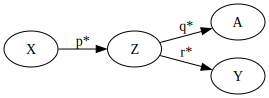

In [67]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Z", "Y")
    ],
    edge_props={
        ("X", "Z"): {"label": "p*"},
        ("Z", "A"): {"label": "q*"},
        ("Z", "Y"): {"label": "r*"}
    },
    graph_direction="LR"
)

In [68]:
n_samples = 1000

X = stats.bernoulli.rvs(p=.5, size=n_samples)

p_star = .9 * X + .1 * (1 - X)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = .9 * Z + .1 * (1 - Z)
A = stats.bernoulli.rvs(p=q_star, size=n_samples)

r_star = .9 * Z + .1 * (1 - Z)
Y = stats.bernoulli.rvs(p=r_star, size=n_samples)

Demonstrate that

- $X \not \perp Y$
- $X \perp Y | Z$


In [69]:
summarize_discrete_counfound_simulation(X, Y, A)

Correlation between X and Y: 0.71
Cross tabulation:
     X    Y
X  425   66
Y   79  430

Correlation between X and Y conditioned on Z=0: 0.43
Cross tabulation:
     X   Y
X  378  40
Y   42  45

Correlation between X and Y conditioned on Z=1: 0.53
Cross tabulation:
    X    Y
X  47   26
Y  37  385


## Discrete Example: Collider Descendant
In this example the descendant branches off of a Collider. Therefore we should observe the following:
- $X \perp Y$
- $X \not \perp Y | Z$
- $X \not \perp Y | A$

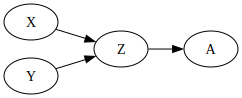

In [70]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "Z"),
        ("Z", "A"),
        ("Y", "Z")
    ],
    graph_direction="LR"
)

$$
\begin{align*}
X &\sim \text{Normal}(0, 1) \\
Y &\sim \text{Normal}(0, 1) \\
Z &\sim \text{Bernoulli}(p^*) \\
A &\sim \text{Bernoulli}(q^*) \\
p^* &= \begin{cases}
    0.9 ,& \text{if } X + Y \gt 2\\
    0.1,              & \text{otherwise}
\end{cases} \\
q^* &= 0.05 Z + 0.95 (1 - Z)
\end{align*}
$$

In [71]:
n_samples = 1000

X = stats.norm.rvs(size=n_samples)
Y = stats.norm.rvs(size=n_samples)

p_star = np.where(X + Y > 2, .9, .1)
Z = stats.bernoulli.rvs(p=p_star, size=n_samples)

q_star = .95 * Z + .05 * (1 - Z)
A = stats.bernoulli.rvs(p=q_star, size=n_samples)

In [72]:
print(f'Correlation between X and Y: {np.corrcoef(X, Y)[0, 1]:1.2}')
for a in [0, 1]:
    print(f'Correlation between X and Y conditioned on A={a}: {np.corrcoef(X[A==a], Y[A==a])[0, 1]:1.2}')
    

Correlation between X and Y: 0.035
Correlation between X and Y conditioned on A=0: -0.081
Correlation between X and Y conditioned on A=1: 0.21


## Descendants are everywhere
- Many measurements aree **proxies** for what we want to measure

## Unobserved Confounds
- Confounds are everywhere, and can ruin your day
- Some controls are better than others
- Often, trying to control for some variables can open up paths to unobserved confounds; we must always be aware of this possibility